In [43]:
import pandas as pd
from sqlalchemy import create_engine

# 데이터베이스 연결 설정
db_host = '192.168.0.39:5432'
db_user = 'postgres'
db_password = '1234'
db_name = 'postgres'
table_name = 'news'

# 데이터베이스 연결
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}')

# 데이터베이스에서 데이터 가져오기
query = f"SELECT * FROM finance_data order by name, date"
df_or = pd.read_sql(query, engine)

In [44]:
df_or.head()

,date,code,name,open,high,low,close,volume
0,2019-01-02,060310,3S,2280.0,2280.0,2160.0,2190.0,24598.0
1,2019-01-03,060310,3S,2195.0,2195.0,2110.0,2180.0,44928.0
2,2019-01-04,060310,3S,2180.0,2395.0,2130.0,2240.0,180908.0
3,2019-01-07,060310,3S,2260.0,2315.0,2225.0,2260.0,77610.0
4,2019-01-08,060310,3S,2230.0,2265.0,2200.0,2250.0,39095.0


In [45]:
df_or['name'].unique()

array(['3S', 'AJ네트웍스', 'AK홀딩스', ..., '흥아해운', '희림', '힘스'], dtype=object)

In [48]:
from tqdm import tqdm
df_list = []
for name in tqdm(df_or['name'].unique()):
    df_list.append(df_or[df_or['name']==name])

100%|██████████| 2593/2593 [05:11<00:00,  8.33it/s]


In [49]:
import warnings
warnings.filterwarnings("ignore")
# 이동평균선(5일, 20일, 60일) 추가
for df in df_list:
    df['5MA'] = df['close'].rolling(window=5).mean()
    df['20MA'] = df['close'].rolling(window=20).mean()
    df['60MA'] = df['close'].rolling(window=60).mean()

In [50]:
df_list[0].head()

,date,code,name,open,high,low,close,volume,5MA,20MA,60MA
0,2019-01-02,060310,3S,2280.0,2280.0,2160.0,2190.0,24598.0,NaN,NaN,NaN
1,2019-01-03,060310,3S,2195.0,2195.0,2110.0,2180.0,44928.0,NaN,NaN,NaN
2,2019-01-04,060310,3S,2180.0,2395.0,2130.0,2240.0,180908.0,NaN,NaN,NaN
3,2019-01-07,060310,3S,2260.0,2315.0,2225.0,2260.0,77610.0,NaN,NaN,NaN
4,2019-01-08,060310,3S,2230.0,2265.0,2200.0,2250.0,39095.0,2224.0,NaN,NaN


In [127]:
knn 분류 선이 그어지면 

AttributeError: 'Series' object has no attribute 'to_datetime'

In [79]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 데이터 불러오기
data = df_list[0]
# 종속 변수 설정
target = 'close'

# 독립 변수 선택
features = ['open', 'high', 'low', 'close', 'volume', '5MA', '20MA', '60MA']

# 데이터 분리 (Train/Test)
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# 데이터 전처리
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

# 시계열 데이터 생성
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length-8):  # 다음 날의 close를 예측하기 위해 -1
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length+1][-8])  # 다음 날의 close 값
    return np.array(X), np.array(y)

seq_length = 10  # 시퀀스 길이 설정
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, len(features))))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 모델 예측
y_pred = model.predict(X_test)

# 예측 결과 분석
# 여기에서는 예측값과 실제값을 비교하여 평가 지표 계산 및 시각화 등을 수행할 수 있습니다.


Epoch 1/10
26/26 [==============================] - 2s 4ms/step - loss: 0.0335
Epoch 2/10
26/26 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3/10
26/26 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 4/10
26/26 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 5/10
26/26 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 6/10
26/26 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 7/10
26/26 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 8/10
26/26 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 9/10
26/26 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


In [82]:
y_pred.shape

(191, 1)

Mean Squared Error (MSE): 0.0021250371729854395
Root Mean Squared Error (RMSE): 0.046098125482338645
Mean Absolute Error (MAE): 0.031518922325715897


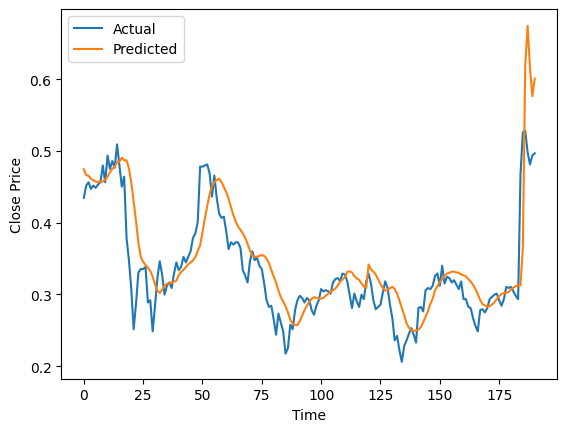

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 평가 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

# 예측 결과 시각화
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [115]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') # For Windows

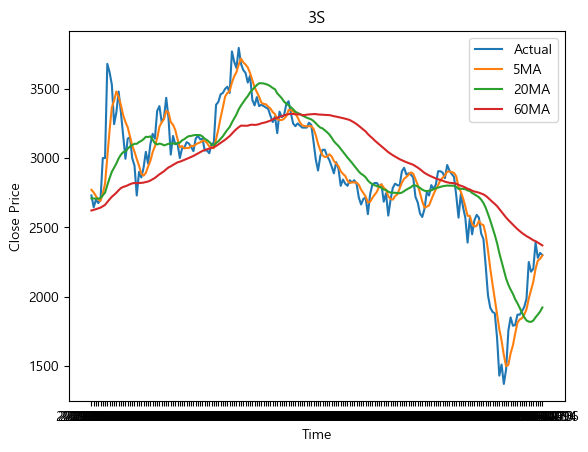

In [124]:
data = df_list[0]

plt.plot(data['date'][60:260],data['close'][60:260], label='Actual')
plt.plot(data['date'][60:260],data['5MA'][60:260], label='5MA')
plt.plot(data['date'][60:260],data['20MA'][60:260], label='20MA')
plt.plot(data['date'][60:260],data['60MA'][60:260], label='60MA')
plt.title(data['name'].iloc[0])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

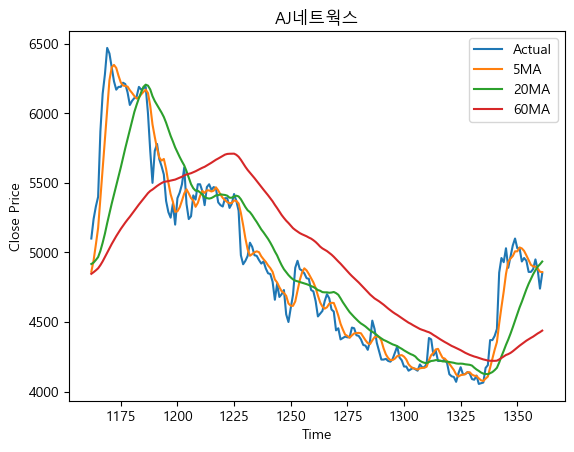

In [118]:
data = df_list[1]
plt.plot(data['close'][60:260], label='Actual')
plt.plot(data['5MA'][60:260], label='5MA')
plt.plot(data['20MA'][60:260], label='20MA')
plt.plot(data['60MA'][60:260], label='60MA')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(data['name'].iloc[0])
plt.legend()
plt.show()

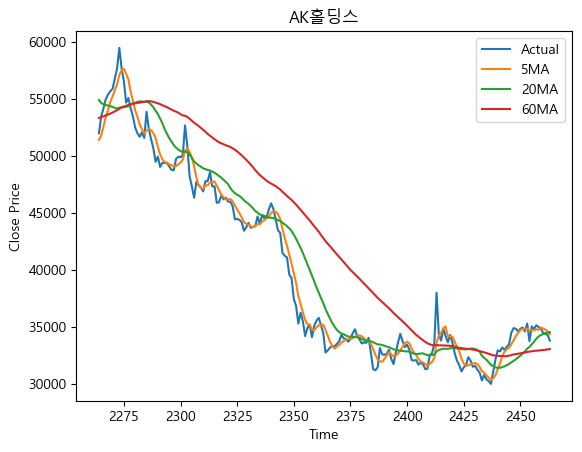

In [122]:
data = df_list[2]
plt.plot(data['close'][60:260], label='Actual')
plt.plot(data['5MA'][60:260], label='5MA')
plt.plot(data['20MA'][60:260], label='20MA')
plt.plot(data['60MA'][60:260], label='60MA')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(data['name'].iloc[0])
plt.legend()
plt.show()

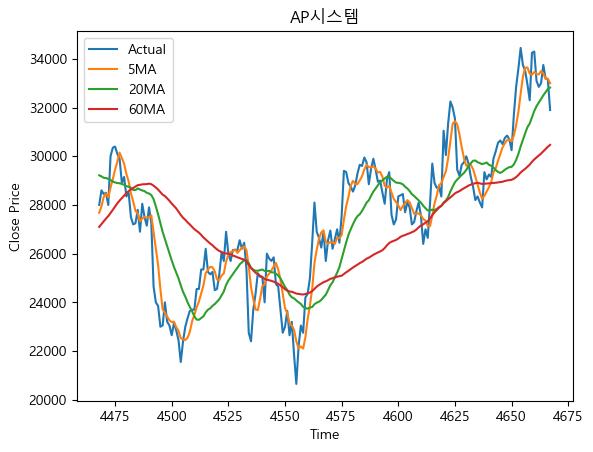

In [123]:
data = df_list[4]
plt.plot(data['close'][60:260], label='Actual')
plt.plot(data['5MA'][60:260], label='5MA')
plt.plot(data['20MA'][60:260], label='20MA')
plt.plot(data['60MA'][60:260], label='60MA')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(data['name'].iloc[0])
plt.legend()
plt.show()

In [121]:
data['name'].iloc[1]

'AP시스템'